# 21M.387 Fundamentals of Music Processing
## Audio Decomposition

An introduction to audio source separation - the task of isolating specific components of a music audio signal. We first examine the inverse Short Time Fourier Transform to reconstruct a signal. Then, we look at Harmonic/Percussive Source Separation and Non-Negative Matrix Factorization.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interact
import sys
sys.path.append("..")
import fmplib as fmp

plt.rcParams['figure.figsize'] = (14, 4)
plt.rcParams['image.interpolation'] = 'nearest'
fmp.documentation_button()

## Reading

Chapter 8.0 – 8.1 (415 – 431), 8.3 (450-468)

<img src="images/book_cover.png" width=200>

## Overview

<img src="images/overview.png" width=600>

## Signal Reconstruction

<font color=red>__Whiteboard__</font>: iDFT

### Inverse DFT
The Discrete Fourier Transform is an invertible process:

The __DFT__ is:
$$X[k] = \sum_{n=0}^{N-1}x[n]e^{-j 2 \pi kn / N } \text{, for } k \in [0:N-1]$$

and $X[k]$ is a set of complex numbers.

The inverse DFT (__iDFT__) is almost identical:
$$x[n] = {1 \over N} \sum_{k=0}^{N-1}X[k]e^{j 2 \pi kn / N } \text{, for } n \in [0:N-1]$$

If $X[k]$ is computed from a real signal, then even though $X[k]$ is complex, __iDFT__($X[k]$) is real. All imaginary components perfectly cancel out.

In [2]:
snd = fmp.load_wav("audio/violin_c4.wav")
fs = 22050.
ipd.Audio(snd, rate=fs, normalize=False)

Create the DFT

In [3]:
snd_ft = np.fft.rfft(snd)

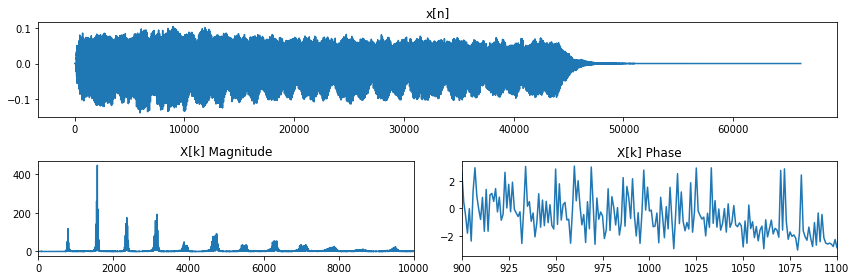

In [4]:
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(snd)
plt.title("x[n]")
plt.subplot(2,2,3)
plt.plot(np.abs(snd_ft))
plt.xlim(0,10000)
plt.title("X[k] Magnitude")
plt.subplot(2,2,4)
plt.plot(np.angle(snd_ft));
plt.xlim(900,1100)
plt.title("X[k] Phase")
plt.tight_layout()

Convert $X[k]$ back to $x[n]$ using `fft.irfft()`

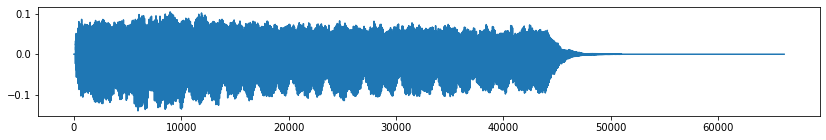

In [5]:
snd_rec = np.fft.irfft(snd_ft)
plt.figure(figsize=(14,2))
plt.plot(snd_rec);

It's fun to make changes to $X[k]$ before reconstruction:

In [6]:
@interact(a=(0.0, 1.0, 0.1))
def filter_snd(a=0.5):
    # create filter curve
    L = len(snd_ft)
    filt = np.interp(np.arange(L), (0,L/10), (a, 1-a)) ** 3
    filt /= np.max(filt)
    
    # apply filter and reconstruct signal
    mod_ft = snd_ft * filt
    snd_rec = np.fft.irfft(mod_ft)

    ymax = np.max(np.abs(snd_ft))
    plt.subplot(1,3,1)
    plt.plot(np.abs(snd_ft))
    plt.ylim(0, ymax)
    plt.title("$X[k]$")
    plt.subplot(1,3,2)
    plt.plot(filt, 'r')
    plt.title("filter:$F[k]$")
    plt.ylim(0,1.3)
    plt.subplot(1,3,3)
    plt.plot(np.abs(mod_ft))
    plt.ylim(0, ymax)
    plt.title("$X[k] \cdot F[k]$")
    plt.show()
    return ipd.Audio(snd_rec, rate=fs, normalize=False)

interactive(children=(FloatSlider(value=0.5, description='a', max=1.0), Output()), _dom_classes=('widget-inter…

### Inverse STFT

<font color=red>__Whiteboard__</font>: iSTFT

We have the STFT, not just the DFT. We must reverse the STFT process.

The STFT of $x[n]$ involves:
- Windowing a signal by some window $w[n]$ of length $N$.
- Taking the length $N$ DFT
- Hopping by $H$

This results in the STFT, $\mathcal{X}[m,k]$ of the original signal $x[n]$, which can be seen as a $K \times M$ matrix where $K = N/2+1$.

For the iSTFT:
- At each hop $m$ of $\mathcal{X}[m,k]$, take the iDFT of $\mathcal{X}[m,k]$ to produce $x^w_m[n]$
- Sum all $x^w_m[n]$ with the correct time shifting to produce $\tilde x[n]$:
$$\tilde x[n] = \sum_{m=0}^{M-1} x^w_m[n - mH]$$
- The length of $x[n]$ is $(M-1)H + N$
- In general $\tilde x[n] \ne x[n]$ because of windowing.
- We must undo the windowing process to recover $x[n]$ from $\tilde x[n]$.

Perfect reconstruction is clearly possible in the simple case of $H=N$ and a rectangular window $w[n]$:
$$
w[n] = 
\left\{
\begin{aligned} 
1,& \text{  if } n \in [0:N-1] \\
0,& \text{  otherwise} \\ 
\end{aligned} 
\right. 
$$

Example: Rectangular Window used in STFT.

In [7]:
x = fmp.load_wav("audio/violin_c4.wav")

@interact(hi=(0,3))
def test_recon(hi=0):
    fft_len = 4096
    hop_size = (4096, int(4096*1.5), int(4096/1.5), 4096//2)[hi]
    spec = fmp.stft(x, fft_len, hop_size, window=np.ones(fft_len))
    
    xr = fmp.istft(spec, hop_size, ignore_windowing=True)
    plt.figure(figsize=(12,5))
    plt.subplot(2,1,1)
    plt.plot(x)
    plt.ylim(-.3, .3)
    plt.title('original x[n]', fontsize=16)
    plt.subplot(2,1,2)
    plt.plot(xr)
    plt.ylim(-.3, .3)
    plt.title(f'reconstructed x[n] with N={fft_len} H={hop_size}', fontsize=16)
    plt.tight_layout()
    plt.show()
    return ipd.Audio(xr, rate=fs, normalize=False)

interactive(children=(IntSlider(value=0, description='hi', max=3), Output()), _dom_classes=('widget-interact',…

For a given window $w[n]$, where the sum of all shifted windows is:
$$ W[n] = \sum_m{w[n - mH]} $$

perfect reconstruction is possible if $W[n] \ne 0$ for all $n$.

To "undo" the effect of windowing present in $\tilde x[n]$, divide by $W[n]$:

$$x_r[n] = {\tilde x[n] \over W[n]}$$

A nice situation is when $W[n] = 1$.

This the case when:
- $w[n]$ is the Hann window (almost)
- $H = N/2$

In [8]:
from scipy.signal import triang

@interact(wt=(0,2), hop=(0,3))
def plot_windows(wt=0, hop=0):
    N = 512
    H = int(N * (1, 1.1, 0.75, 0.5)[hop])
    win = (np.ones(N), triang(N), np.hanning(N))[wt]
    hops = 5
    win_sum = np.zeros(N + (hops-1) * H)

    plt.figure(figsize=(12,4))
    plt.subplot(2,1,1)
    for n in range(hops):
        win_shift = np.zeros(len(win_sum))
        win_shift[n*H:n*H+N] += win
        win_sum += win_shift
        plt.plot(win_shift)
    plt.ylim(0, 2.1)
    plt.xlim(0, 3000)
    plt.title(f'windows N={N}, H={H}', fontsize=20)
    plt.subplot(2,1,2)
    plt.plot(win_sum)
    plt.ylim(0, 2.1);
    plt.xlim(0, 3000)
    plt.title('sum of windows: W[n]', fontsize=20)
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=0, description='wt', max=2), IntSlider(value=0, description='hop', max=3…

### Reconstruction Example

- Load audio
- Create STFT

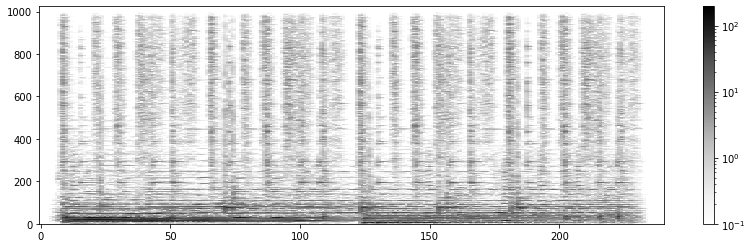

In [9]:
snd = fmp.load_wav("audio/latin_loop.wav")
stft = fmp.stft(snd, 2048, 512)
fmp.plot_spectrogram(np.abs(stft), cmap='Greys')
ipd.Audio(snd, rate = fs)

- Inverse STFT
- Play

In [10]:
snd_r = fmp.istft(stft, 512 )
ipd.Audio(snd_r, rate = fs)

- Monkey around with STFT first by creating and applying a mask
- Inverse STFT
- Play

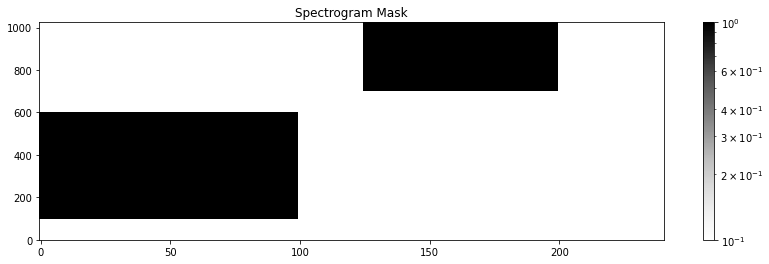

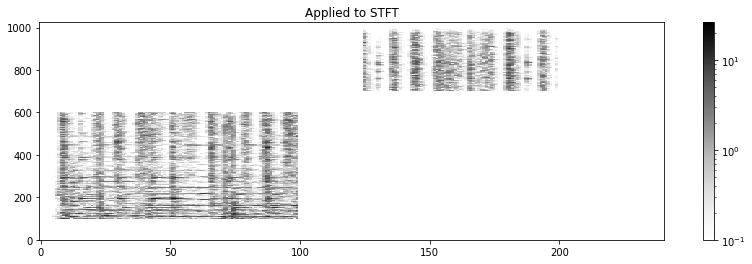

In [11]:
example_mask = np.zeros(stft.shape)
example_mask[100:600, 0:100] = 1
example_mask[700:, 125:200] = 1

stft_masked = stft * example_mask
snd_masked = fmp.istft(stft_masked, 512)

fmp.plot_spectrogram(example_mask, cmap='Greys')
plt.title("Spectrogram Mask")
plt.show()
plt.title("Applied to STFT")
fmp.plot_spectrogram(np.abs(stft_masked), cmap='Greys')
plt.show()

ipd.Audio(snd_masked, rate = fs)

## Harmonic / Percussive Source Separation (HPSS)

In [12]:
def spec_and_play(filepath):
    fs = 22050.
    snd = fmp.load_wav(filepath)
    spec = fmp.stft_mag(snd, 2048, 1024)
    fmp.plot_spectrogram(spec[0:300,:], cmap='Greys')
    return ipd.Audio(snd, rate=fs)

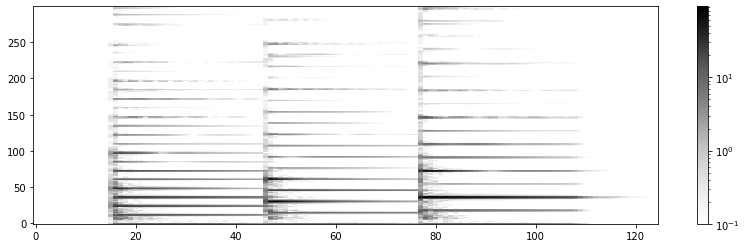

In [13]:
spec_and_play("audio/piano_CEG_octaves.wav")

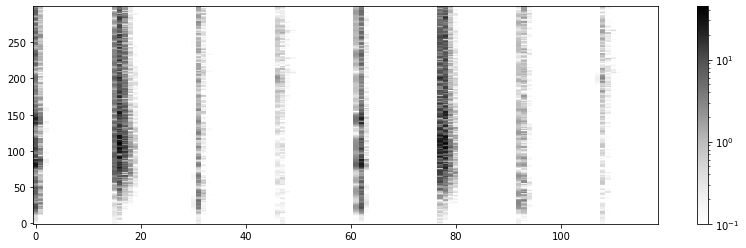

In [14]:
spec_and_play("audio/hits.wav")

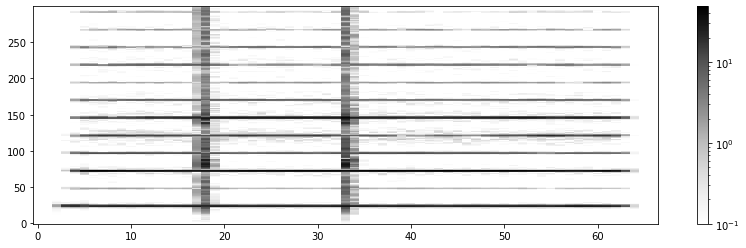

In [15]:
spec_and_play("audio/clarinet_hits.wav")

Observations:

- Horizontal lines
  - tonal or harmonic sound
  - modeled as steady sinusoids
  - narrow-band frequency range
  
  
- Vertical lines
  - percussive hits or sharp onsets
  - modeled as an impulse
  - wide-band frequency range
  

- Many sounds are one or the other or a combination
- Some sounds are neither (noise, applause)

### Goal

<font color=red>__Whiteboard__</font>: HPSS

Separate a time-based signal $x[n]$ into a harmonic component $x^h[n]$ and a percussive component $x^p[n]$ such that:
$$x[n] = x^h[n] + x^p[n]$$

Strategy:
- Convert $x[n]$ to the STFT: $\mathcal{X}[n,k]$
- Separate $\mathcal{X}[n,k]$ into two parts: $\mathcal{X}^h[n,k]$ and $\mathcal{X}^p[n,k]$ by:
  - Applying a harmonic filter to $\mathcal{X}[n,k]$ to create $\mathcal{X}^h[n,k]$
  - Applying a percussive filter to $\mathcal{X}[n,k]$ to create $\mathcal{X}^p[n,k]$ 
- Use the iSTFT to convert $\mathcal{X}^h[n,k]$ to $x^h[n]$ and $\mathcal{X}^p[n,k]$ to $x^p[n]$

### Identifying Outliers
Begin with the (power) spectrogram
$$\mathcal{Y}[n,k] = \vert \mathcal{X}[n,k] \vert ^2$$

Look at a single frequency $k_0$ across all $n$: a horizontal slice of $\mathcal{Y}[n,k]$ defined as $\mathcal{Y}^{k_0}[n] = \mathcal{Y}[n,k_0]$.  
A percussive event at some time $n_0$ is a spike in $\mathcal{Y}^{k_0}[n]$.

In [16]:
snd = fmp.load_wav("audio/clarinet_hits.wav")
fs = 22050.
stft = fmp.stft(snd, 2048, 1024)
spec = np.abs(stft) ** 2

@interact(k=(90,105))
def plot_hslice(k=90):
    hline = spec[k,:]
    plt.figure(figsize=(12,6))
    plt.subplot(2,1,1)
    fmp.plot_spectrogram(spec[0:150,:], cmap='Greys', colorbar=False)
    plt.hlines(k, 0, 60, 'r')
    plt.subplot(2,1,2)
    plt.plot(hline)
    plt.xlim(0,len(hline))
    plt.ylim(0, 200)
    plt.title(f"slice at k={k}")
    plt.show()

interactive(children=(IntSlider(value=90, description='k', max=105, min=90), Output()), _dom_classes=('widget-…

Similarly, look at a single time $n_0$ across all $k$: a vertical slice of $\mathcal{Y}[n,k]$ defined as $\mathcal{Y}^{n_0}[k] = \mathcal{Y}[n_0,k]$.  
A harmonic event at some frequency $k_0$ is a spike in $\mathcal{Y}^{n_0}[k]$.

In [17]:
@interact(n=(28,38))
def plot_hslice(n=25):
    vline = spec[0:250, n]
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    fmp.plot_spectrogram(spec[0:250,:], cmap='Greys', colorbar=False)
    plt.vlines(n, 0, 250, 'r')
    plt.ylim(0, 250)
    plt.subplot(1,2,2)
    plt.plot(vline, np.arange(len(vline)))
    plt.xlim(0, 500)
    plt.ylim(0, 250)
    plt.title(f"slice at n={n}")
    plt.show()

interactive(children=(IntSlider(value=28, description='n', max=38, min=28), Output()), _dom_classes=('widget-i…

These spikes in the horizontal and vertical lines can be considered _outliers_.  
Outliers of a signal can be removed by __median filtering__.

### Median

The median of a list of numbers is the half-way point of that list sorted.

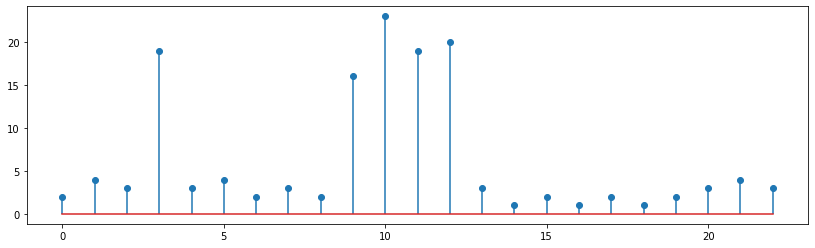

In [18]:
x = np.array((2,4,3,19,3,4,2,3,2,16,23,19,20,3,1,2,1,2,1,2,3,4,3,))
plt.stem(x);

Sort $x$ and pick mid-point

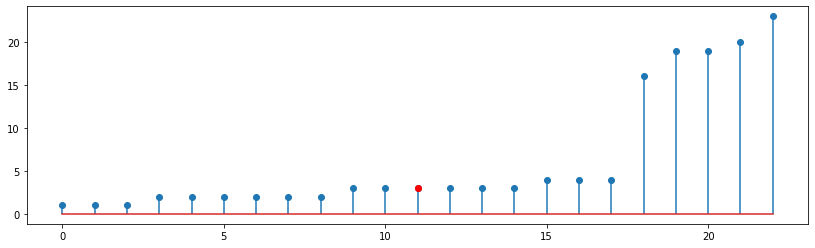

In [19]:
xs = np.sort(x)
plt.stem(xs);
mp = (len(xs)-1) // 2
plt.plot(mp, xs[mp], 'ro');

In [20]:
print('Median:', np.median(x))
print('Mean:', np.mean(x))

Median: 3.0
Mean: 6.173913043478261


In [21]:
@interact(mm=False)
def show_mm(mm):
    plt.stem(x);
    m = np.mean(x) if mm else np.median(x)
    plt.title(("Median", "Mean")[mm])
    plt.hlines(m, 0, 25, 'r')
    plt.show()

interactive(children=(Checkbox(value=False, description='mm'), Output()), _dom_classes=('widget-interact',))

Note: if $\text{len}(x)$ is even, average the two midpoints.

### Median Filter

A _median filter_ applied to a signal $x[n]$ produces the signal $\tilde{x}[n]$ where $\tilde{x}[n_0]$ is median of the values in the length $L$ window of $x[n]$ centered around $n_0$.

- $L$ is usually odd.
- $x[n]$ is zero-padded by ${L-1 \over 2}$ on both sides to handle the edge cases.

In [22]:
from scipy.signal import medfilt

@interact(mm=False, L=(1,9,2))
def plot_filter(mm=False, L=1):
    xm = np.convolve(x, np.ones(L)/float(L), mode='same') if mm else medfilt(x, L)
    plt.figure(figsize=(12,5))
    plt.subplot(2,1,1)
    plt.stem(x)
    plt.subplot(2,1,2)
    plt.ylim(0, 25)
    plt.title(("Median Filtered", "Mean Filtered")[mm])
    plt.stem(xm)
    plt.show()

interactive(children=(Checkbox(value=False, description='mm'), IntSlider(value=1, description='L', max=9, min=…

Median Filters tend to:
- eliminate spikes
- retain edges

### Creating Masks

We now apply median filtering to all rows of $\mathcal{Y}[n,k]$ to create 
$\tilde{\mathcal{Y}}^h[n,k]$

In [23]:
@interact(L=(1,15,2))
def plot_filter(L=1):
    spec_h = medfilt(spec, (1, L))
    fmp.plot_spectrogram(spec_h[0:300], cmap='Greys', colorbar=False)
    plt.title(f"Harmonic Median Filtered Spectrogram with L={L}")
    plt.show()

interactive(children=(IntSlider(value=1, description='L', max=15, min=1, step=2), Output()), _dom_classes=('wi…

And to the columns of $\mathcal{Y}[n,k]$ to create 
$\tilde{\mathcal{Y}}^p[n,k]$

In [24]:
@interact(L=(1,27,2))
def plot_filter(L=1):
    spec_p = medfilt(spec, (L, 1))
    fmp.plot_spectrogram(spec_p[0:250], cmap='Greys', colorbar=False)
    plt.title(f"Percussive Median Filtered Spectrogram with L={L}")
    plt.show()

interactive(children=(IntSlider(value=1, description='L', max=27, min=1, step=2), Output()), _dom_classes=('wi…

We are not done yet!

Instead of using these filtered spectrograms directly, we use them to create masks that can operate on the original STFT:

These are __binary masks__. They "assign" a STFT cell to be either harmonic or percussive:

$$
\mathcal{M}^h[n,k] = 
\left\{
\begin{aligned} 
1,& \text{  if } \tilde{\mathcal{Y}}^h[n,k] \ge \tilde{\mathcal{Y}}^p[n,k] \\ 
0,& \text{  otherwise} \\ 
\end{aligned} 
\right. 
$$

$$
\mathcal{M}^p[n,k] = 
\left\{
\begin{aligned} 
1,& \text{  if } \tilde{\mathcal{Y}}^h[n,k] \lt \tilde{\mathcal{Y}}^p[n,k] \\ 
0,& \text{  otherwise} \\ 
\end{aligned} 
\right. 
$$


Here is what they look like

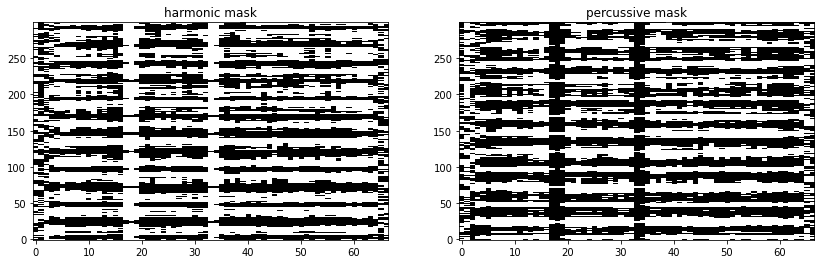

In [25]:
spec_h = medfilt(spec, (1, 11))
spec_p = medfilt(spec, (27, 1))

bmask_h = spec_h >= spec_p
bmask_p = np.logical_not(bmask_h)

plt.subplot(1,2,1)
fmp.plot_spectrogram(bmask_h[0:300,:], cmap='Greys', colorbar=False)
plt.title("harmonic mask")
plt.subplot(1,2,2)
plt.title("percussive mask")
fmp.plot_spectrogram(bmask_p[0:300,:], cmap='Greys', colorbar=False)

We apply these masks onto the original STFT $\mathcal{X}[n,k]$ by doing a point-by-point multiplication:

$$\mathcal{X}^h[n,k] = \mathcal{M}^h[n,k] \cdot \mathcal{X}[n,k]$$
$$\mathcal{X}^p[n,k] = \mathcal{M}^p[n,k] \cdot \mathcal{X}[n,k]$$

Remember that $\mathcal{X}[n,k]$ is complex-valued, and so are $\mathcal{X}^h[n,k]$ and $\mathcal{X}^p[n,k]$.

Results of applying masks:

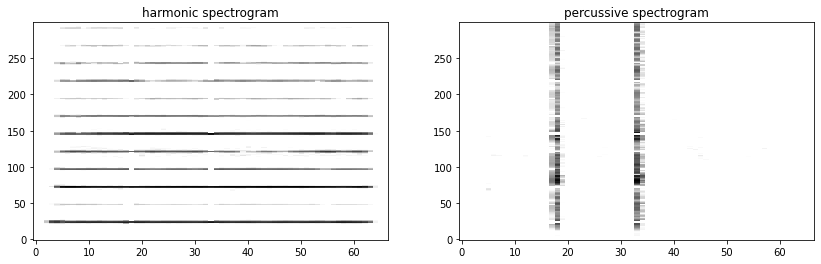

In [26]:
spec_h = bmask_h * spec
spec_p = bmask_p * spec

plt.subplot(1,2,1)
fmp.plot_spectrogram(spec_h[0:300,:], cmap='Greys', colorbar=False)
plt.title("harmonic spectrogram")
plt.subplot(1,2,2)
plt.title("percussive spectrogram")
fmp.plot_spectrogram(spec_p[0:300,:], cmap='Greys', colorbar=False)

While binary masks work fine, it is often better to have "softer edges" to our masking filters. These are __soft masks__, also known as __Wiener filtering__:

$$ \mathcal{M}^h[n,k] = {  \tilde{\mathcal{Y}}^h[n,k] + {\epsilon \over 2} \over \tilde{\mathcal{Y}}^h[n,k] + \tilde{\mathcal{Y}}^p[n,k] + \epsilon }$$

$$ \mathcal{M}^p[n,k] = {  \tilde{\mathcal{Y}}^p[n,k] + {\epsilon \over 2} \over \tilde{\mathcal{Y}}^h[n,k] + \tilde{\mathcal{Y}}^p[n,k] + \epsilon }$$

They look like this:

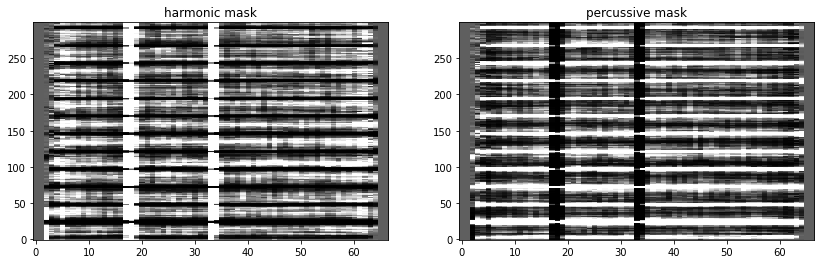

In [27]:
spec_h = medfilt(spec, (1, 11))
spec_p = medfilt(spec, (27, 1))

eps = 0.0001
denom = (spec_h + spec_p + eps)
smask_h = (spec_h + eps/2) / denom
smask_p = (spec_p + eps/2) / denom

plt.subplot(1,2,1)
fmp.plot_spectrogram(smask_h[0:300,:], cmap='Greys', colorbar=False)
plt.title("harmonic mask")
plt.subplot(1,2,2)
plt.title("percussive mask")
fmp.plot_spectrogram(smask_p[0:300,:], cmap='Greys', colorbar=False)

It makes a small difference here, but a bigger difference with more complex music.

### Reconstruction

The final step is to convert $\mathcal{X}^h[n,k]$ and $\mathcal{X}^p[n,k]$ back into the time domain.

Apply soft masks to STFT

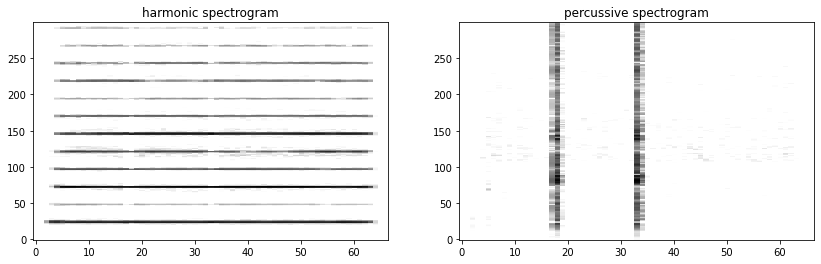

In [28]:
stft_h = smask_h * stft
stft_p = smask_p * stft

plt.subplot(1,2,1)
fmp.plot_spectrogram(np.abs(stft_h[0:300,:]), cmap='Greys', colorbar=False)
plt.title("harmonic spectrogram")
plt.subplot(1,2,2)
plt.title("percussive spectrogram")
fmp.plot_spectrogram(np.abs(stft_p[0:300,:]), cmap='Greys', colorbar=False)

In [29]:
snd_h = fmp.istft(stft_h, 1024)
ipd.Audio(snd_h, rate = fs)

In [30]:
snd_p = fmp.istft(stft_p, 1024)
ipd.Audio(snd_p, rate = fs)

Another example:

In [31]:
snd = fmp.load_wav("audio/latin_loop.wav")
ipd.Audio(snd, rate = fs)

Apply HPSS:

In [32]:
snd_h, snd_p = fmp.hpss(snd, h_filt_len=19, p_filt_len=31, fft_len=4096)

Harmonic Signal:

In [33]:
ipd.Audio(snd_h, rate = fs)

Percussive Signal:

In [34]:
ipd.Audio(snd_p, rate = fs)

### Applications

- Isolating drum hits as a precursor to percussion identification tasks
- Pre-processing step for other MIR methods:

<img src="images/chroma_and_onsets.png" width=800>

## Non-Negative Matrix Factorization

__Goal__: to decompose music into notewise audio events

<img src="images/score_decomp.png" width=400>

<font color=red>__Whiteboard__</font>: NMF


To illustrate, start with a spectrogram-like matrix $V$, a $K \times N$ matrix (in this example, $K = 11$ and $N = 7$).

<img src="images/NMF_toy1.png" width=250>

$V$ can be _factored_ into the product of two smaller matrices:
- $W$, a $K \times R$ matrix - the __templates__ matrix.
- $H$, a $R \times N$ matrix - the __activations__ matrix.
- Here, $R = 3$

<img src="images/NMF_toy2.png" width=400>

$$V = W \cdot H$$

- NMF is a factorization where all cells in $W$, $H$ (and of course $V$) are non-negative.
- Goal: to find $W$ and $H$ such that $V \approx W H$.
- $R$ is the __rank__ of the factorization. Should be relatively small.
- Want $H$ and $W$ to "mean something" useful.

### Factorization by Gradient Descent

For the gory details, see text, pages 454-459.

Optimization problem: find $W$ and $H$ so as to minimize the Euclidean distance:
$$\phi = {\Vert V - W H \Vert}$$

Gradient Descent is an iterative process:  
- Initialize $W$ and $H$ somehow (either random values or some other way)
- Make small changes to $W$ and $H$, thereby moving towards a local minimum in the distance metric.
- Stop when $\phi$ stops changing by very much.
- NMF factorization has a special property that keeps all values of $W$ and $H$ positive.

The update step for modifying $W$ and $H$ are:
$$H = H \odot W^\top V \oslash (W^\top W H)$$
$$W = W \odot V H^\top  \oslash (W H H^\top)$$

Note: $\odot$ and $\oslash$ are symbols for _elementwise_ multiplication and division.

#### Example
First 4 bars of Mozart's _Piano Sonata in C_.  
Create $\mathcal{X}[n,k]$, the STFT of $x[n]$, with $N=4096$, $H=1024$.

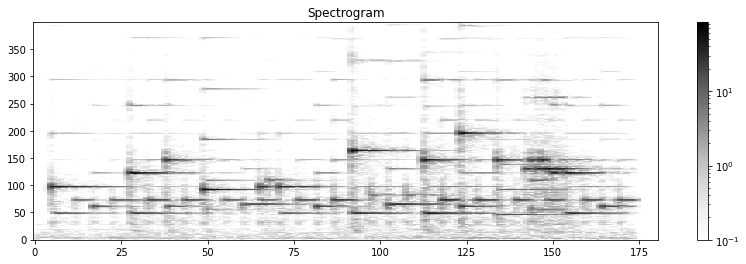

In [35]:
snd = fmp.load_wav("audio/mozart_sonata_c.wav")
fs = 22050.

fft_len = 4096
hop_size = fft_len // 4
stft = fmp.stft(snd, fft_len, hop_size)
fmp.plot_spectrogram(np.abs(stft[0:400,:]), cmap='Greys')
plt.title("Spectrogram")
ipd.Audio(snd, rate=fs)

Score:
<img src="images/mozart_sonata_c.png" width=600>

To run NMF:
- $V = \vert \mathcal{X}[n,k]\vert$
- Initialize $H$ and $W$ to be random values
- Choose $R = 15$ (why 15?)

In [36]:
V = np.abs(stft)

K, N = V.shape
R = 15
print(f'K={K}\nN={N}\nR={R}')

Wi = np.random.random((K, R))
Hi = np.random.random((R, N))

K=2049
N=181
R=15


Run gradient decent:

In [37]:
stages = fmp.nmf_descent_stages(V, Wi, Hi)

@interact(s=(0, len(stages)-1))
def show_stage(s=0):
    i,W,H,err = stages[s]
    plt.subplot(1,2,1)
    plt.imshow(np.log(W[0:500,:] + 0.001), origin='lower', aspect='auto')
    plt.title('W', fontsize=15)
    plt.subplot(1,2,2)
    plt.imshow(H, origin='lower', aspect='auto')
    plt.title('H', fontsize=15)
    plt.text(-100, 16, f'iteration= {i}. ||V - WH|| = {err:.2f}', fontsize=15)
    plt.show()

interactive(children=(IntSlider(value=0, description='s', max=43), Output()), _dom_classes=('widget-interact',…

This looks interesting. $H$ and $W$ have some structure. But we want something better.


Initialize $W$ to be a more meaningful template:
- One column per piano note found in the score. 
- Look at the sheet music to get the pitches.

They are:

In [38]:
mozart_pitches = (59, 60, 62, 64, 65, 67, 69, 71, 72, 74, 76, 77, 79, 81, 84)

Construct $W$ with a harmonic model of these 15 pitches:

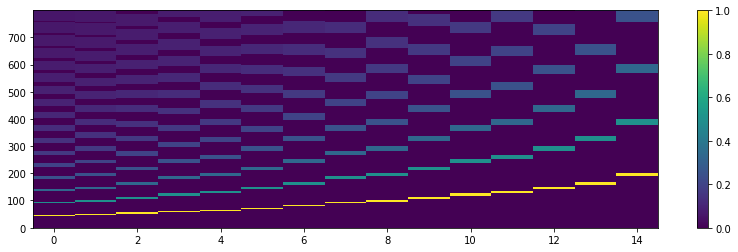

In [39]:
Wi = fmp.make_nmf_template(fs, fft_len, mozart_pitches)
plt.imshow(Wi[0:800,:], origin='lower', aspect='auto')
plt.colorbar();

In [40]:
Hi = np.ones((R,N))
stages = fmp.nmf_descent_stages(V, Wi, Hi)
@interact(s=(0, len(stages)-1))
def show_stage(s=0):
    i,W,H,err = stages[s]
    plt.subplot(1,2,1)
    plt.imshow(np.log(W[0:500,:] + 0.001), origin='lower', aspect='auto')
    plt.title('W', fontsize=15)
    plt.subplot(1,2,2)
    plt.imshow(H, origin='lower', aspect='auto')
    plt.title('H', fontsize=15)
    plt.text(-100, 16, 'iteration= %d. |V - WH| = %.2f' % (i, err), fontsize=15)
    plt.show()

interactive(children=(IntSlider(value=0, description='s', max=43), Output()), _dom_classes=('widget-interact',…

Now $H$ looks much more like sheet music (or MIDI representation).

### Analysis of $H$ (activations)

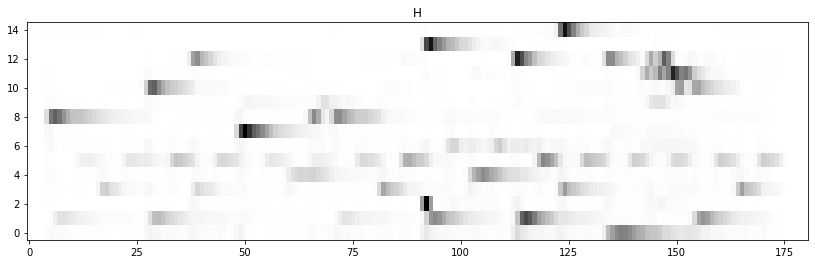

In [41]:
Hi = np.ones((R, N))
Wo, Ho = fmp.nmf(V, Wi, Hi)
plt.imshow(Ho, origin='lower', aspect='auto', cmap='Greys')
plt.title('H');

Let's look at each activation row:

In [42]:
H_smooth = fmp.temporal_smoothing(Ho, 5, 'hann', False)
@interact(p=(0,Ho.shape[0]-1), smooth_and_peaks=False)
def plot_activation(p=0, smooth_and_peaks=False):
    act = H_smooth[p,:] if smooth_and_peaks else Ho[p,:]
    plt.plot(act)
    plt.ylim(0, 4.0)
    
    if smooth_and_peaks:
        peaks = fmp.find_peaks(act, 0.2)
        peaks = peaks[ act[peaks] > .25 ]
        plt.plot(peaks, act[peaks], 'ro')
    
    plt.title(f"activation for pitch={mozart_pitches[p]}", fontsize=15)
    plt.show()

interactive(children=(IntSlider(value=0, description='p', max=14), Checkbox(value=False, description='smooth_a…

Use peaks to locate pitches in time and synthesize:

In [43]:
def pick_notes(H, pitches):
    notes = []
    for i in range(H.shape[0]):
        h = H[i,:]
        times = fmp.find_peaks(h, 0.2)
        times = times[ h[times] > .25 ]
        notes += [(pitches[i], t * hop_size / fs, .25) for t in times]
    notes.sort()
    return notes

notes = pick_notes(H_smooth, mozart_pitches)
melody = fmp.synthesize_sequence(notes, fs)
ipd.Audio(melody, rate=fs)

### Analaysis of $W \cdot H$

We can recreate an approximation of the original Spectrogram with:
$$V' = W \cdot H$$

In [44]:
Vo = np.dot(Wo, Ho)

@interact(approx=False)
def compare_specs(approx):
    X = Vo if approx else V
    txt = "V' = WH" if approx else 'original spec'
    fmp.plot_spectrogram(X[0:400,:], cmap='Greys')
    plt.title(txt, fontsize=15)
    plt.show()

interactive(children=(Checkbox(value=False, description='approx'), Output()), _dom_classes=('widget-interact',…

Note data compression: $W \cdot H$ takes $10 \times$ less memory.

In [45]:
print(f'Spec size = {K} x {N} = {K*N}')
print(f'W + H size = {K} x {R} + {R} x {N} = {K*R + R*N}')

Spec size = 2049 x 181 = 370869
W + H size = 2049 x 15 + 15 x 181 = 33450


Let's listen to $W \cdot H$ by creating $x_r$ with iSTFT:

In [46]:
x_r = fmp.istft(Vo, hop_size)
ipd.Audio(x_r, rate=fs)

What happened? Why does this sound bad?

Remember that $V'$ has only real values, whereas the STFT $\mathcal{X}[n,k]$ is a complex matrix.  
$V'$ alone has no phase information!  
We can copy the phase information from $\mathcal{X}[n,k]$ to $V'$

In [47]:
spec_r = fmp.merge_mag_phase(Vo, stft)
x_r = fmp.istft(spec_r, hop_size)
ipd.Audio(x_r, rate=fs)

### NMF-based Source Separation

We can do a lot more with $H$. For example, we can separate the left and right hands of the piano recording.

Here is $H$ again:

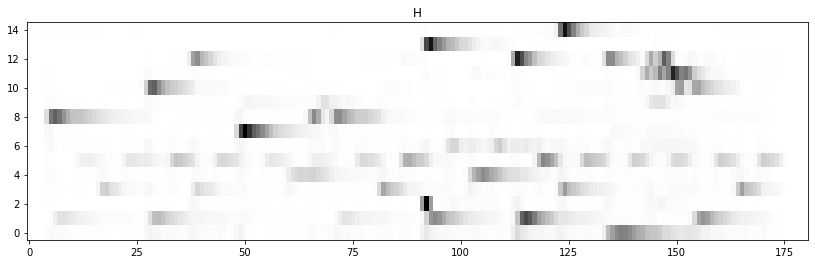

In [48]:
plt.imshow(Ho, origin='lower', aspect='auto', cmap='Greys')
plt.title('H')
plt.show()

Left hand pitches are in $H$ with rows $h \in [0,6] \rightarrow H^L$.  
Right hand pitches are in $H$ with rows $h \in [7,14] \rightarrow H^R$.

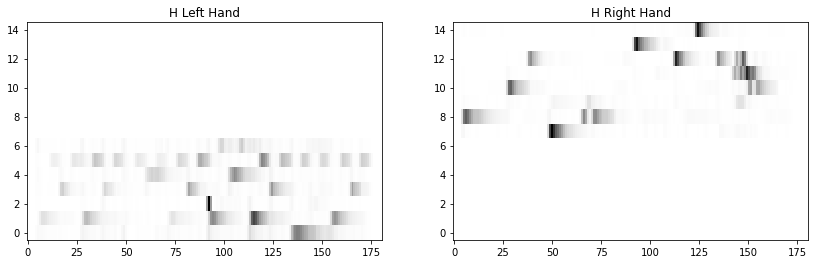

In [49]:
## left / right split:
H_left = Ho.copy()
H_left[7:,:] = 0
H_right = Ho.copy()
H_right[0:7,:] = 0 

plt.subplot(1,2,1)
plt.imshow(H_left, origin='lower', aspect='auto', cmap='Greys')
plt.title("H Left Hand")
plt.subplot(1,2,2)
plt.imshow(H_right, origin='lower', aspect='auto', cmap='Greys')
plt.title("H Right Hand");

Create soft masks (similarly to HPSS) from $H^L$ and $H^R$ instead of using them directly:

$$M^L = (WH^L) \oslash (WH + \epsilon)$$
$$M^R = (WH^R) \oslash (WH + \epsilon) $$

As in HPSS, apply these masks to the original STFT $\mathcal{X}[n,k]$ and convert back to audio with the ISTFT.

In [50]:
# create masked reconstructions
x_left  = fmp.mask_and_reconstruct(Wo, Ho, H_left, stft, hop_size)
x_right = fmp.mask_and_reconstruct(Wo, Ho, H_right, stft, hop_size)

display( ipd.Audio(x_left, rate=fs) )
display( ipd.Audio(x_right, rate=fs) )

This is just an introduction to NMF. Many variations exist that do a better job. For example:
- score informed NMF to initialize $H$ with rough locations of notes
<img src="images/initialized_H.png" width=500>

- add accommodation for percussive transients for each piano note in $W$ and $H$.
<img src="images/NMF_with_transients.png" width=500>